In [24]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Galaxy Color Distribution

In [25]:
# load sample selection
from astropy.table import Table
fpath = '../../data/SDSS_Main/'
fname = 'sdss_vagc.hdf5'
t = Table.read(fpath+fname, path='data')

# define cosmology
from galaxy_shapes.sdss_measurements.default_cosmology import cosmo
#from astropy.cosmology import FlatLambdaCDM
#cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05, Tcmb0=2.7255)

# sample absolute magnitude limit as a function of redshift
from astro_utils.magnitudes import absolute_magnitude_lim
z = np.linspace(0.001,0.5,100)
Mr_lim = absolute_magnitude_lim(z, 17.77, cosmo=cosmo)

# see Yang et al. (2009) eq. 3, 4, and 5
from galaxy_shapes.sdss_measurements.sdss_utils import maximum_redshift
mm = np.linspace(-24,-16,1000) # sample magnitudes
zz = maximum_redshift(mm) # returns redshift limit

# define (g-r) color
color = np.array(t['ABSMAG_g0.1'] - t['ABSMAG_r0.1'])

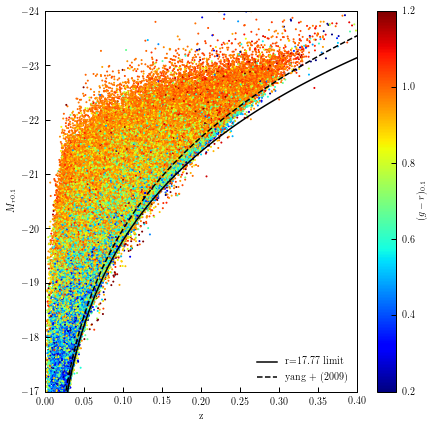

In [26]:
# magnitude vs redshift

fig = plt.figure(figsize=(7,7))
plt.scatter(t['Z'], t['ABSMAG_r0.1'],
            s=1, c=color, vmin=0.2, vmax=1.2, cmap='jet')
l1, = plt.plot(z, Mr_lim, '-', color='black')
l2, = plt.plot(zz, mm, '--', color='black')
plt.xlim([0,0.4])
plt.ylim([-17,-24])
plt.xlabel('z')
plt.ylabel(r'$M_{r0.1}$')
plt.colorbar(label=r'$(g-r)_{0.1}$')
plt.legend([l1,l2],['r=17.77 limit','yang + (2009)'],
           loc='lower right', fontsize=10, frameon=False)
plt.show()

In [27]:
# make completeness cut
from galaxy_shapes.sdss_measurements.estimate_completeness import z_lim
zz = maximum_redshift(t['ABSMAG_r0.1'], cosmo=cosmo)
comp_mask = (t['Z'] <= zz)
t=t[comp_mask]
color = color[comp_mask]

## Measure Color Distribution

In [81]:
mag_bins = np.arange(-23,-16.9,0.5)[::-1]
mag_bin_centers = (mag_bins[:-1]+mag_bins[1:])/2.0
color_bins = np.arange(0,1.4,0.05)
xsample=np.linspace(0,1.5,1000)

In [82]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
gmm = GaussianMixture(n_components=2, means_init=[[0.3],[1.0]])

0 5278 True
1 8491 True
2 13193 True
3 21573 True
4 37274 True
5 59682 True
6 77870 True
7 91605 True
8 82386 True
9 52731 True
10 21217 True
11 5149 True


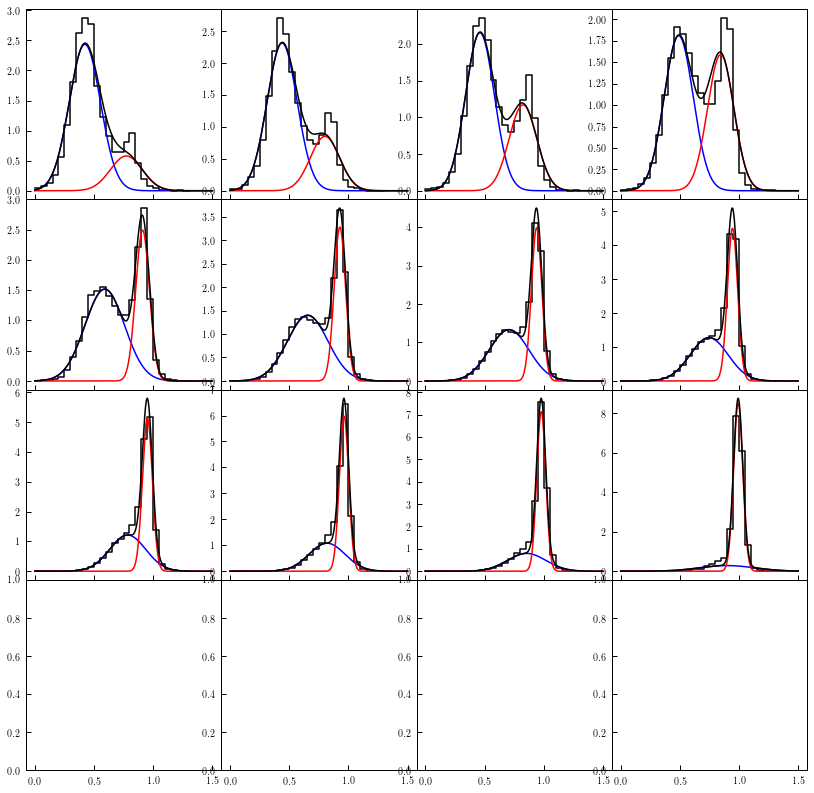

In [91]:
# row and column sharing
fig, axes = plt.subplots(4, 4, sharex=True, sharey=False, figsize=(14.0,14.0))
axes = axes.flatten()
plt.subplots_adjust(wspace=0, hspace=0)

N = len(mag_bins)-1
m1s = np.zeros(N)
m2s = np.zeros(N)
s1s = np.zeros(N)
s2s = np.zeros(N)
fs = np.zeros(N)
for i in range(0,N):
    mask = (t['ABSMAG_r0.1']<mag_bins[i]) & (t['ABSMAG_r0.1']>mag_bins[i+1])
    N = np.sum(mask)
    
    X = color[mask]
    X = X.reshape((N,1))
    res = gmm.fit(X)
    m1, m2 = res.means_
    s1, s2 = np.sqrt((res.covariances_[0][0], res.covariances_[1][0]))
    f = res.weights_[0]
    
    m1s[i] = m1
    m2s[i] = m2
    s1s[i] = s1
    s2s[i] = s2
    fs[i] = f
    
    counts = np.histogram(color[mask], bins=color_bins)[0]
    counts = 1.0*counts/np.sum(counts)/np.diff(color_bins)
    ax = axes[i]
    ax.step(color_bins[:-1], counts, where='post', color='black')
    
    ax.plot(xsample, f*norm.pdf(xsample, loc=m1, scale=s1), color='blue')
    ax.plot(xsample, (1-f)*norm.pdf(xsample, loc=m2, scale=s2), color='red')
    ax.plot(xsample, f*norm.pdf(xsample, loc=m1, scale=s1)+(1-f)*norm.pdf(xsample, loc=m2, scale=s2), color='black')
    
    print(i, N, res.converged_)
    

plt.show()

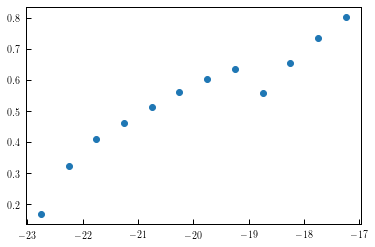

In [92]:
plt.plot(mag_bin_centers, fs, 'o')
plt.xlim()

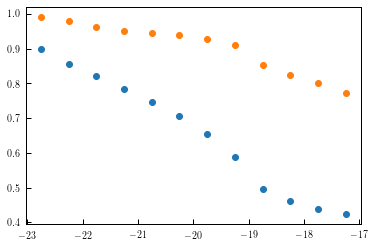

In [89]:
plt.plot(mag_bin_centers, m1s, 'o')
plt.plot(mag_bin_centers, m2s, 'o')

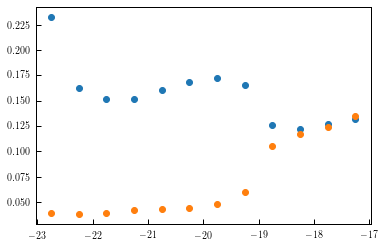

In [90]:
plt.plot(mag_bin_centers, s1s, 'o')
plt.plot(mag_bin_centers, s2s, 'o')